In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
import pandas as pd
%matplotlib inline
np.random.seed(1)
import scipy.io
tf.disable_v2_behavior()
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
import cv2

In [0]:
import tensorflow_hub as hub

In [0]:
train_x = pd.read_csv("/content/drive/My Drive/flower_recog/train.csv")

In [0]:
valid_x = pd.read_csv("/content/drive/My Drive/flower_recog/valid.csv")

In [0]:
train_x.set_index('Unnamed: 0',drop = True,inplace=True)
valid_x.set_index('Unnamed: 0',drop = True,inplace=True)

In [0]:
X = train_x.iloc[:,:-1].values
Y = train_x['Labels'].values

In [0]:
X = X.reshape(len(train_x),128,128,3)
X1 = valid_x.iloc[:,:-1].values
Y1 = valid_x['Labels'].values
X1 = X1.reshape(len(valid_x),128,128,3)
X = X/255
X1 = X1/255
from sklearn.preprocessing import OneHotEncoder
Y_trans = OneHotEncoder().fit_transform(Y.reshape(-1,1)).toarray()
Y1_trans = OneHotEncoder().fit_transform(Y1.reshape(-1,1)).toarray()

In [0]:
image = []
for i in range(1020):
  image.append(cv2.resize(X[i,:,:,:],(299,299)))

In [0]:
X = np.array(image)

In [12]:
image = []
for i in range(1020):
  image.append(cv2.resize(X1[i,:,:,:],(299,299)))
X1 = np.array(image)
X1.shape

(1020, 299, 299, 3)

y = 45


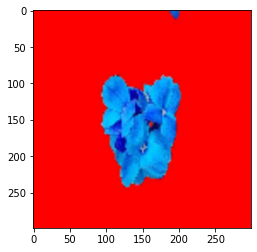

In [16]:
import matplotlib.pyplot as plt
index = 3
plt.imshow(X[index])
print("y = " + str((Y[index])))

In [0]:
#from sklearn.model_selection import train_test_split

In [0]:
#X_train ,X_test ,Y_train, Y_test = train_test_split(X,Y_trans,test_size = 0.2, random_state = 10)

In [0]:
#X_train = X_train/255
#X_test = X_test/255

In [0]:
#X_train = X_train.reshape(len(X_train),150,150,3)
#X_test = X_test.reshape(len(X_test),150,150,3)

In [0]:
def batches(X_train,Y_train):
    X_train_set = []
    Y_train_set = []
    for i in range(len(X_train)//128):
        X_train_set.append(X_train[i*128:(i+1)*128,:,:,:])
        Y_train_set.append(Y_train[i*128:(i+1)*128,:])
    return X_train_set,Y_train_set    

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    return X, Y

In [1]:
"""def initialize_parameters():
    
    tf.set_random_seed(1)                              #
    W1 = tf.get_variable("W1", [3,3,3,64], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W2 =tf.get_variable("W2", [3,3,64,128], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W3 =tf.get_variable("W3", [3,3,128,128], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    W4 =tf.get_variable("W4", [3,3,128,256], initializer =tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3,
                  "W4": W4}
    
    return parameters"""

'def initialize_parameters():\n    \n    tf.set_random_seed(1)                              #\n    W1 = tf.get_variable("W1", [3,3,3,64], initializer =tf.contrib.layers.xavier_initializer(seed = 0))\n    W2 =tf.get_variable("W2", [3,3,64,128], initializer =tf.contrib.layers.xavier_initializer(seed = 0))\n    W3 =tf.get_variable("W3", [3,3,128,128], initializer =tf.contrib.layers.xavier_initializer(seed = 0))\n    W4 =tf.get_variable("W4", [3,3,128,256], initializer =tf.contrib.layers.xavier_initializer(seed = 0))\n    parameters = {"W1": W1,\n                  "W2": W2,\n                  "W3": W3,\n                  "W4": W4}\n    \n    return parameters'

ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [0]:
def forward_propagation(X):
    module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")
    outputs = module(X)
    Z5 = tf.layers.dense(inputs=outputs, units=102)
    return Z5

In [0]:
def compute_cost(Z5, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z5, labels = Y))
  
    
    return cost

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, print_cost = True):

    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)


    Z5 = forward_propagation(X)

    cost = compute_cost(Z5, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
     

    with tf.Session() as sess:

        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0
            X_set , Y_set = batches(X_train, Y_train)

            for x,y in zip(X_set,Y_set):

                minibatch_X, minibatch_Y = x,y

                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
  
                
                minibatch_cost += temp_cost / len(X_set)
                


            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()


        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        os.mkdir('/sodel')
        tf.saved_model.simple_save(sess, '/sodel', inputs={"X": X}, outputs={"Z5": Z5})
        print('--- MODEL SAVED ---')        
        return train_accuracy, test_accuracy

In [0]:
_, _= model(X2, Y2_trans, X1, Y1_trans)

In [0]:
test_x = pd.read_csv("/content/drive/My Drive/flower_recog/test.csv")

In [0]:
test_x.set_index('Unnamed: 0',drop = True,inplace=True)

In [0]:
X2 = test_x.iloc[:,:-1].values
Y2 = test_x['Labels'].values

In [0]:
X2 = X2[:4000]
Y2 = Y2[:4000]

In [0]:
X2 = X2.reshape(len(X2),128,128,3)

In [0]:
X2.shape

(1000, 128, 128, 3)

In [0]:
X2 = X2/255

In [0]:
image = []
for i in range(len(X2)):
  image.append(cv2.resize(X2[i,:,:,:],(299,299)))
X2 = np.array(image)
X2.shape

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
Y2_trans = OneHotEncoder().fit_transform(Y2.reshape(-1,1)).toarray()

In [0]:
graph1 = tf.Graph()
with graph1.as_default():
    with tf.Session(graph=graph1) as sess:
        tf.saved_model.loader.load(sess, ["serve"], '/fodel')
        x = graph1.get_tensor_by_name('X:0')
        y_predict = graph1.get_tensor_by_name('Y:0')
        predictions = sess.run(y_predict, feed_dict={x: X,y_predict:Y_trans})

INFO:tensorflow:Restoring parameters from /todel/variables/variables


INFO:tensorflow:Restoring parameters from /todel/variables/variables


In [0]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(np.argmax(predictions), Y_trans), tf.float32))